In [12]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.io import wavfile

import fast_bss_eval

In [14]:
configs = ['classical', 'jazz']
results = pd.DataFrame(columns=['config', 'category', 'algo', 'SDR', 'SIR', 'SAR'])
for config in configs:
    categories = [f.name for f in os.scandir(config) if f.is_dir()]
    for category in categories:
        # show all wav files in the category
        wav_files = [f.name for f in os.scandir(f'{config}/{category}') if f.is_file() and f.name.endswith('.wav')]
        if 'reference.wav' in wav_files:
            # read the reference wav file
            # ref_wav, sr = sf.read(f'{config}/{category}/reference.wav')
            fs, ref_wav = wavfile.read(f'{config}/{category}/reference.wav')
            wav_files.remove('reference.wav')
        else:
            print(f'Error: No reference.wav file found in {config}/{category}')
        for wav_file in wav_files:
            # read the wav file
            # eval_wav, sr = sf.read(f'{config}/{category}/{wav_file}')
            fs, eval_wav = wavfile.read(f'{config}/{category}/{wav_file}')            
            sdr, sir, sar, _ = fast_bss_eval.bss_eval_sources(ref_wav.T, eval_wav.T)
            sdr, sir, sar = np.mean(sdr), np.mean(sir), np.mean(sar)
            # results = results.append({'config': config, 'category': category, 'wav_file': wav_file, 'SDR': sdr, 'ISR': sir, 'SIR': sar, 'SAR': perm}, ignore_index=True)
            result_row = pd.DataFrame({'config': [config], 'category': [category], 'algo': [wav_file.split('.')[0]], 'SDR': [sdr], 'SIR': [sir], 'SAR': [sar]})
            results = pd.concat([results, result_row], ignore_index=True)

# replace 'algo' with proper names
results['algo'] = results['algo'].replace({'fastmnmf2':'FastMNMF2', 'ilrma':'ILRMA', 'demuc':'HT-Demucs', 'spleeter':'Spleeter', 'gaussian':'GaussianMNMF'})

/var/folders/4v/n41dv2b1147ds406__7xy7zm0000gn/T/ipykernel_37708/3723026231.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, result_row], ignore_index=True)


In [15]:
# export as csv for results
results.to_csv('objective_eval.csv', index=False)

# plot

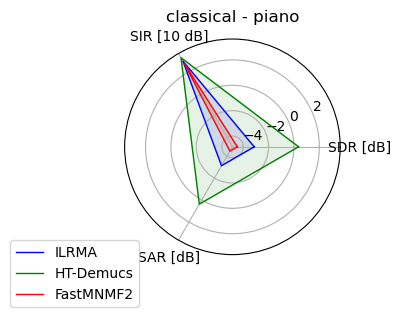

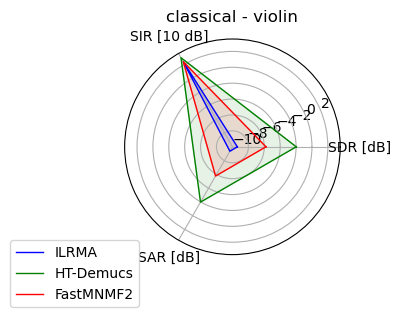

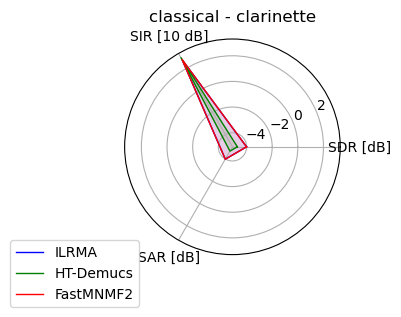

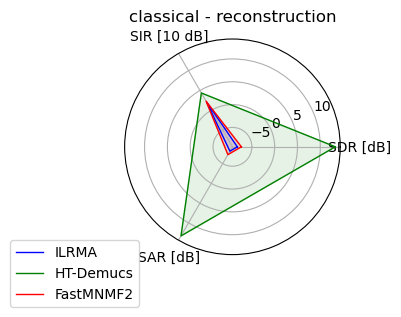

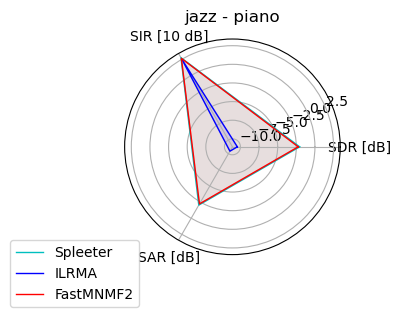

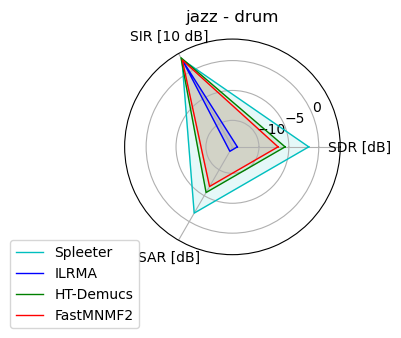

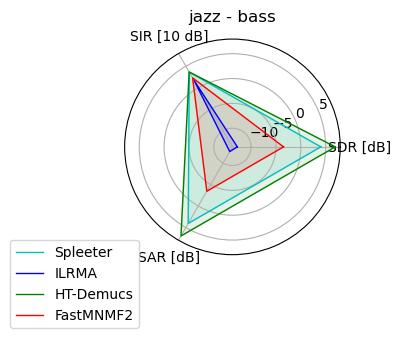

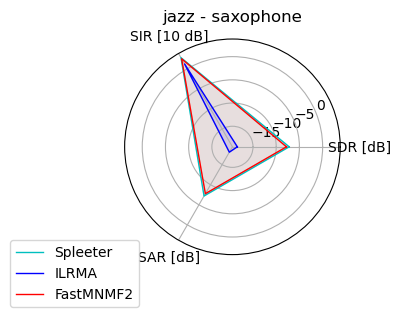

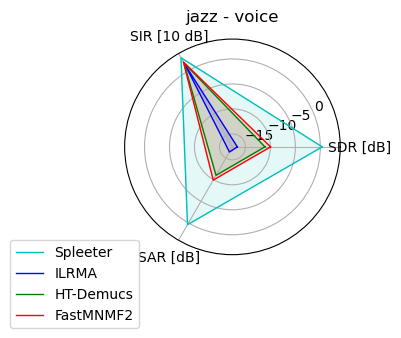

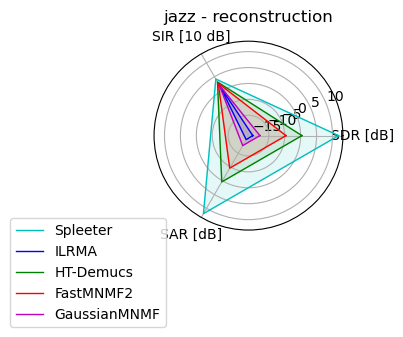

In [16]:
try:
    results
except NameError:
    results = pd.read_csv('objective_eval.csv')
    print(f'Loading objective_eval.csv')
    
from math import pi

labels = list(results.columns[3:])
N = len(labels)

# 计算角度
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
colors = {algo: color for algo, color in zip(results['algo'].unique(), colors)}

for config in configs:
    categories = results[results['config'] == config]['category'].unique()
    for category in categories:     
        # 初始化雷达图
        fig, ax = plt.subplots(figsize=(4, 4), subplot_kw=dict(polar=True))

        # Filter the DataFrame for the specific config and category
        filtered_results = results[(results['config'] == config) & (results['category'] == category)]

        # 绘制每个类别的数据
        for i, (index, row) in enumerate(filtered_results.iterrows()):
            values = row[labels].values.flatten().tolist()
            # SIR need to divide by 10
            values = [v/10 if label == 'SIR' else v for label, v in zip(labels, values)]
            values += values[:1]
            color = colors[row['algo']]
            ax.plot(angles, values, linewidth=1, linestyle='solid', label=f"{row['algo']}", color=color)
            ax.fill(angles, values, alpha=0.1, color=color)

        # 添加标签
     
        plt.xticks(angles[:-1], ['SDR [dB]', 'SIR [10 dB]', 'SAR [dB]'])

        # 添加图例
        plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
        plt.title(f'{config} - {category}')
        plt.tight_layout()
        plt.savefig(f'save_fig/{config}_{category}.png', dpi=300)
plt.show()